In [6]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [7]:
import argparse
import copy
from tqdm import tqdm
from statistics import mean, stdev
from sklearn import metrics

import torch
import json
from tree_ring.inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import open_clip
from tree_ring.optim_utils import *
from tree_ring.io_utils import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import re


In [8]:
def get_watermarking_mask(init_latents_w, w_radius, device, w_channel=3):
    watermarking_mask = torch.zeros(init_latents_w.shape, dtype=torch.bool).to(
        device
    )
    np_mask = circle_mask(init_latents_w.shape[-1], r=w_radius)
    torch_mask = torch.tensor(np_mask).to(device)

    if w_channel == -1:
        # all channels
        watermarking_mask[:, :] = torch_mask
    else:
        watermarking_mask[:, w_channel] = torch_mask
    return watermarking_mask

In [9]:
parser = argparse.ArgumentParser(description='diffusion watermark')
parser.add_argument('--model_id', default='/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/')
parser.add_argument('--test_num_inference_steps', default=None, type=int)
parser.add_argument('--num_inference_steps', default=50, type=int)

# watermark
parser.add_argument('--w_mask_shape', default='circle')

parser.add_argument('--w_measurement', default='l1_complex')
parser.add_argument('--w_radius', default=10)
parser.add_argument('--w_channel', default=0, type=int)


# for image distortion

parser.add_argument('--orig_img_no_w_path',default='../datas/videos/text2video-zero/dynamic_radius/8frames_uniform' ,type=str)
parser.add_argument('--orig_img_w_path',default='../datas/videos/text2video-zero/dynamic_radius/8frames_uniform_w', type=str)
parser.add_argument('--radius_path',default='../datas/videos/text2video-zero/dynamic_radius/test/radius', type=str)

args = parser.parse_args([])

if args.test_num_inference_steps is None:
    args.test_num_inference_steps = args.num_inference_steps

In [10]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision='fp16',
    )
pipe = pipe.to(device)

In [11]:
tester_prompt = '' # assume at the detection time, the original prompt is unknown
text_embeddings = pipe.get_text_embedding(tester_prompt)

# ground-truth patch
gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)
init_latents_w = pipe.get_random_latents()
no_w_metrics=[]
w_metrics=[]

/tmp/ipykernel_1484140/1026452446.py:5: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)


In [12]:
for idx_video in range(100):
    print(f'---------------------idx_video:{idx_video}----------------------------')
    for idx_frame in range(8):
        frame_path_no_w = f'{args.orig_img_no_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'
        frame_path_w = f'{args.orig_img_w_path}/sent{idx_video}_frames/frame{idx_frame}.jpg'

        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)
        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)

        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)

        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )

        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=50,
        )
        with open(args.radius_path+'/'+str(idx_video)+'_w.json', 'r') as file:
            json_data = file.read()
        dic_radius = json.loads(json_data)
        w_radius = dic_radius[str(idx_frame)]
        print('--------------------')
        print(f'w_radius:{w_radius}')
        watermarking_mask = get_watermarking_mask(init_latents_w, w_radius, device)

        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)

---------------------idx_video:0----------------------------


100%|██████████| 50/50 [00:00<00:00, 51.60it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.67it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.10it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.74it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.88it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


--------------------
w_radius:11
---------------------idx_video:1----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.72it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.03it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.79it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.64it/s]


--------------------
w_radius:11
---------------------idx_video:2----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.78it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.31it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 56.38it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.97it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.18it/s]


--------------------
w_radius:16
---------------------idx_video:3----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.41it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.58it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.73it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.89it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.27it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.10it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:16
---------------------idx_video:4----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.92it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.47it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.05it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.25it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.19it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 56.15it/s]


--------------------
w_radius:15
---------------------idx_video:5----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.66it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 56.00it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.37it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.86it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.26it/s]


--------------------
w_radius:10
---------------------idx_video:6----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.95it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.95it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.81it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.18it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.37it/s]


--------------------
w_radius:14
---------------------idx_video:7----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.40it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.95it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.77it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.68it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.25it/s]


--------------------
w_radius:15
---------------------idx_video:8----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.76it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.47it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.93it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.26it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.34it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.38it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.26it/s]


--------------------
w_radius:12
---------------------idx_video:9----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.24it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.19it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.81it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.66it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:16
---------------------idx_video:10----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 50.67it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.03it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.73it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.02it/s]


--------------------
w_radius:10
---------------------idx_video:11----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.73it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.15it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.22it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.14it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


--------------------
w_radius:16
---------------------idx_video:12----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.74it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.53it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.24it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.25it/s]


--------------------
w_radius:13
---------------------idx_video:13----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.55it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.70it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.03it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


--------------------
w_radius:16
---------------------idx_video:14----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.29it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.15it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.43it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.05it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.31it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.50it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:13
---------------------idx_video:15----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.96it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.07it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.22it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.17it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.44it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:10
---------------------idx_video:16----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.30it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.67it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.49it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.55it/s]


--------------------
w_radius:15
---------------------idx_video:17----------------------------


100%|██████████| 50/50 [00:00<00:00, 51.72it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.03it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 51.67it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.73it/s]


--------------------
w_radius:10
---------------------idx_video:18----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.53it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.87it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.82it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.83it/s]


--------------------
w_radius:16
---------------------idx_video:19----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.79it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.84it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 50.71it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.42it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.22it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


--------------------
w_radius:10
---------------------idx_video:20----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.41it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 52.43it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.84it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.91it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.53it/s]


--------------------
w_radius:13
---------------------idx_video:21----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.27it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.07it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.25it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.29it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.58it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.73it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.81it/s]


--------------------
w_radius:14
---------------------idx_video:22----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.29it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.10it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.34it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.52it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.47it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:15
---------------------idx_video:23----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.53it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.55it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 56.33it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.21it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:11
---------------------idx_video:24----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.60it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.14it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.32it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:01<00:00, 48.81it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.50it/s]


--------------------
w_radius:16
---------------------idx_video:25----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.88it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.18it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.54it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.91it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.63it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.27it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.87it/s]


--------------------
w_radius:12
---------------------idx_video:26----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.04it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.46it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.73it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.00it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:15
---------------------idx_video:27----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.82it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.65it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.44it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.39it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:14
---------------------idx_video:28----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.04it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 56.09it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.21it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.85it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.52it/s]


--------------------
w_radius:11
---------------------idx_video:29----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.05it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.74it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.64it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.68it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.20it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:13
---------------------idx_video:30----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.87it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.99it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.04it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.30it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 52.23it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.20it/s]


--------------------
w_radius:16
---------------------idx_video:31----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.03it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.21it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.72it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.36it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.10it/s]


--------------------
w_radius:16
---------------------idx_video:32----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.99it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.94it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.68it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.66it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.01it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.00it/s]


--------------------
w_radius:16
---------------------idx_video:33----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.74it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.51it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 52.88it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.39it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:15
---------------------idx_video:34----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.04it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.53it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.14it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.17it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.89it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 51.90it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:11
---------------------idx_video:35----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.24it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.94it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.96it/s]


--------------------
w_radius:11
---------------------idx_video:36----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.21it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.35it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.94it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.44it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.18it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 56.12it/s]


--------------------
w_radius:16
---------------------idx_video:37----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.06it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.88it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.23it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 56.16it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:10
---------------------idx_video:38----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.25it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.76it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.87it/s]


--------------------
w_radius:13
---------------------idx_video:39----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.24it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.92it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.76it/s]


--------------------
w_radius:15
---------------------idx_video:40----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.65it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.83it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.75it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.09it/s]


--------------------
w_radius:15
---------------------idx_video:41----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.73it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.43it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.81it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.92it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.74it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.11it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.25it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.73it/s]


--------------------
w_radius:10
---------------------idx_video:42----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.41it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.90it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.06it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.03it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.25it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.35it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.55it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.18it/s]


--------------------
w_radius:12
---------------------idx_video:43----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.74it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.81it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.95it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.92it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:14
---------------------idx_video:44----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.00it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 50.44it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.19it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 51.85it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 51.59it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.43it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.23it/s]


--------------------
w_radius:13
---------------------idx_video:45----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.48it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.60it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.05it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.05it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.68it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.07it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.07it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:16
---------------------idx_video:46----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.49it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 51.18it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.88it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.39it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.71it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.15it/s]


--------------------
w_radius:11
---------------------idx_video:47----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.93it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.97it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.15it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.03it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.74it/s]


--------------------
w_radius:10
---------------------idx_video:48----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.33it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.03it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.09it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 56.29it/s]


--------------------
w_radius:14
---------------------idx_video:49----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.96it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.41it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.94it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.51it/s]


--------------------
w_radius:13
---------------------idx_video:50----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.28it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.03it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.59it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.88it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.13it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.48it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.55it/s]


--------------------
w_radius:10
---------------------idx_video:51----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.88it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.23it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.09it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.83it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.48it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:13
---------------------idx_video:52----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.16it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.84it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.87it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.05it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


--------------------
w_radius:10
---------------------idx_video:53----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.17it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.36it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.55it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.53it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.37it/s]


--------------------
w_radius:13
---------------------idx_video:54----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.95it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.35it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.39it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.61it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:11
---------------------idx_video:55----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.04it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.96it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.37it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.46it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.20it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:11
---------------------idx_video:56----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.47it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.17it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.17it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.07it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.92it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.71it/s]


--------------------
w_radius:10
---------------------idx_video:57----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.46it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.01it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.91it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:16
---------------------idx_video:58----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.41it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.55it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.73it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:10
---------------------idx_video:59----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.20it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.73it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.94it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.67it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 51.48it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:12
---------------------idx_video:60----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.97it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.51it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.81it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.39it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.66it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.10it/s]


--------------------
w_radius:10
---------------------idx_video:61----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.26it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.01it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.80it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.97it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.83it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.90it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:15
---------------------idx_video:62----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.08it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.58it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.02it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.66it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.72it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.03it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.24it/s]


--------------------
w_radius:15
---------------------idx_video:63----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.20it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.13it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.68it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.18it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.39it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


--------------------
w_radius:12
---------------------idx_video:64----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.48it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.67it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.34it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.30it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 51.34it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.48it/s]


--------------------
w_radius:10
---------------------idx_video:65----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.00it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.16it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.45it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.20it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.09it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.22it/s]


--------------------
w_radius:12
---------------------idx_video:66----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.85it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.05it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.06it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.25it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.10it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.58it/s]


--------------------
w_radius:15
---------------------idx_video:67----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.82it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.41it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.36it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.97it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.22it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.78it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.84it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.06it/s]


--------------------
w_radius:13
---------------------idx_video:68----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.15it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.86it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.24it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.70it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.91it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.64it/s]


--------------------
w_radius:10
---------------------idx_video:69----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.87it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.02it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 56.32it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.85it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.75it/s]


--------------------
w_radius:14
---------------------idx_video:70----------------------------


100%|██████████| 50/50 [00:00<00:00, 51.95it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.46it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.72it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.08it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 56.13it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.27it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.77it/s]


--------------------
w_radius:14
---------------------idx_video:71----------------------------


100%|██████████| 50/50 [00:00<00:00, 56.13it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.02it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.84it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.06it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.50it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:10
---------------------idx_video:72----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.95it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.61it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 51.16it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.68it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:12
---------------------idx_video:73----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.59it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.68it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.81it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.00it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.99it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.15it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 51.37it/s]


--------------------
w_radius:10
---------------------idx_video:74----------------------------


100%|██████████| 50/50 [00:01<00:00, 48.30it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.94it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.30it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 56.05it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.56it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.76it/s]


--------------------
w_radius:11
---------------------idx_video:75----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.53it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 56.23it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.53it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 54.71it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.30it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.67it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.84it/s]


--------------------
w_radius:10
---------------------idx_video:76----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.10it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.18it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.90it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.41it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.24it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 56.07it/s]


--------------------
w_radius:13
---------------------idx_video:77----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.71it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.62it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.23it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.59it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:01<00:00, 49.24it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.76it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.86it/s]


--------------------
w_radius:10
---------------------idx_video:78----------------------------


100%|██████████| 50/50 [00:00<00:00, 50.29it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.84it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 52.96it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:01<00:00, 49.07it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 51.92it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.70it/s]


--------------------
w_radius:10
---------------------idx_video:79----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.53it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.70it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.05it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.95it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:10
---------------------idx_video:80----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.73it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.45it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.13it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.38it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 52.21it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 52.47it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.47it/s]


--------------------
w_radius:14
---------------------idx_video:81----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.12it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.01it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.96it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.40it/s]


--------------------
w_radius:10
---------------------idx_video:82----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.15it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.99it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.19it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.34it/s]


--------------------
w_radius:10
---------------------idx_video:83----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.40it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.65it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.39it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.51it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.61it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.87it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 50.46it/s]


--------------------
w_radius:15
---------------------idx_video:84----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.22it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.10it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.93it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.91it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.05it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.33it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.18it/s]


--------------------
w_radius:10
---------------------idx_video:85----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.92it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 56.10it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.75it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.66it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.96it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 53.78it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.37it/s]


--------------------
w_radius:11
---------------------idx_video:86----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.25it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.57it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.34it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.76it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.66it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.50it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.90it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:11
---------------------idx_video:87----------------------------


100%|██████████| 50/50 [00:00<00:00, 52.59it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.61it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.21it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.80it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.47it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.83it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:15
---------------------idx_video:88----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.13it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.72it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.47it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.63it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.12it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 53.59it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 54.72it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.60it/s]


--------------------
w_radius:10
---------------------idx_video:89----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.48it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.46it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 52.38it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.67it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.17it/s]


--------------------
w_radius:12
---------------------idx_video:90----------------------------


100%|██████████| 50/50 [00:00<00:00, 53.14it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.81it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.54it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.98it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.16it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.38it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:10
---------------------idx_video:91----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.34it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.23it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.72it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.23it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.22it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 52.50it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.24it/s]


--------------------
w_radius:16
---------------------idx_video:92----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.52it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 56.18it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.86it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.22it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.19it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 53.33it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 52.75it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.69it/s]


--------------------
w_radius:10
---------------------idx_video:93----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.00it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.49it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.94it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.29it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.74it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.42it/s]


--------------------
w_radius:10
---------------------idx_video:94----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.70it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.89it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 51.12it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.31it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.94it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:10
---------------------idx_video:95----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.28it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.83it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 54.19it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 53.31it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.72it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.43it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


--------------------
w_radius:14
---------------------idx_video:96----------------------------


100%|██████████| 50/50 [00:00<00:00, 54.14it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 51.11it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.10it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.52it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.71it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.89it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.53it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.48it/s]


--------------------
w_radius:13
---------------------idx_video:97----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.32it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.65it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 53.61it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 54.78it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.82it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 53.25it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 52.30it/s]


--------------------
w_radius:14
---------------------idx_video:98----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.34it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.64it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 54.77it/s]


--------------------
w_radius:12


100%|██████████| 50/50 [00:00<00:00, 55.78it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.98it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 55.60it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.72it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 55.20it/s]


--------------------
w_radius:10
---------------------idx_video:99----------------------------


100%|██████████| 50/50 [00:00<00:00, 55.83it/s]


--------------------
w_radius:11


100%|██████████| 50/50 [00:00<00:00, 55.13it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 54.76it/s]


--------------------
w_radius:10


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


--------------------
w_radius:14


100%|██████████| 50/50 [00:00<00:00, 53.83it/s]


--------------------
w_radius:13


100%|██████████| 50/50 [00:00<00:00, 54.61it/s]


--------------------
w_radius:16


100%|██████████| 50/50 [00:00<00:00, 55.79it/s]


--------------------
w_radius:15


100%|██████████| 50/50 [00:00<00:00, 55.76it/s]

--------------------
w_radius:12


In [13]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.9081250000000001


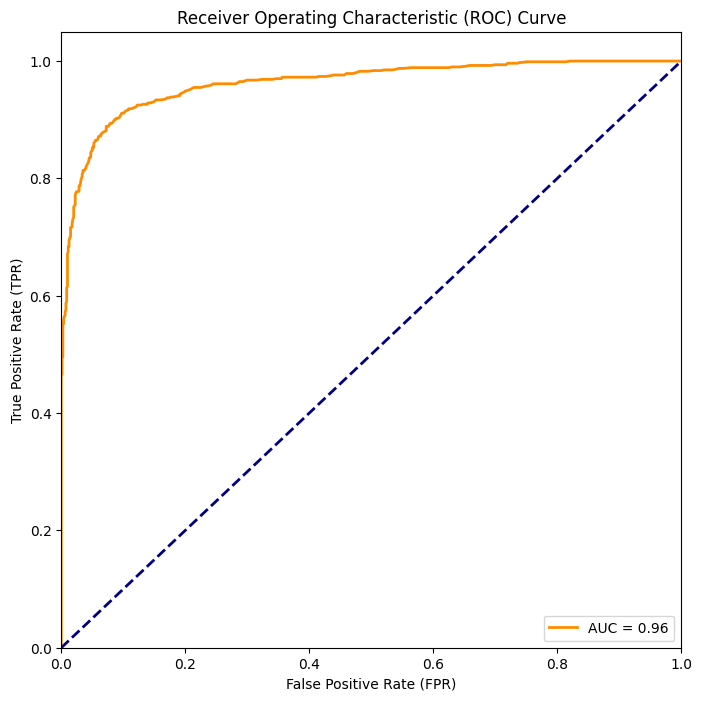

In [14]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

In [16]:
preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.98


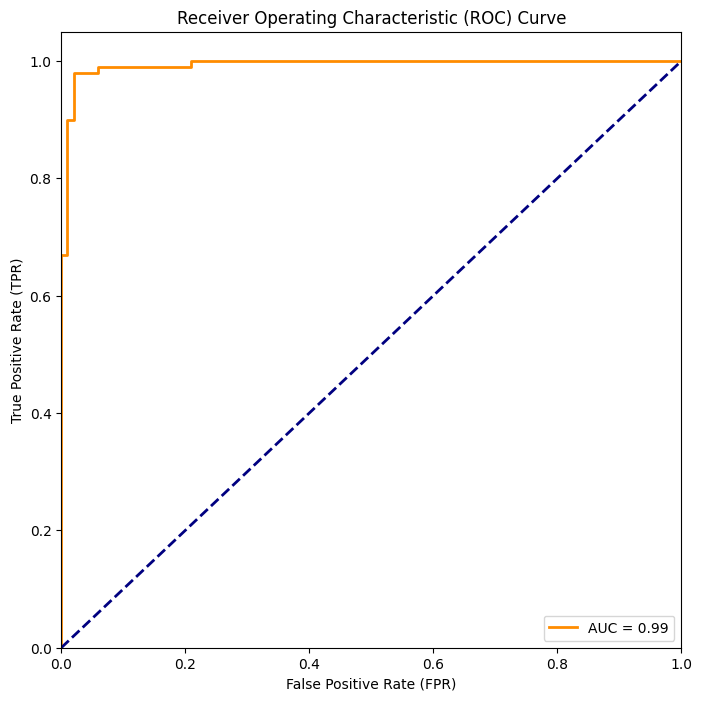

In [17]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()